# Assignment 1

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms


import matplotlib.pyplot as plt

In [2]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 128
num_workers = 2
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=1e-4,
    weight_decay=1e-6,
)


# preprocessing pipeline for input images
transformation = dict()

for data_type in ("train", "test"):
    is_train = data_type=="train"

    if is_train:
        transformation[data_type] = tv_transforms.Compose([
            tv_transforms.TrivialAugmentWide(),
            tv_transforms.RandomRotation(degrees=15),
            tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            tv_transforms.RandomHorizontalFlip(),

            tv_transforms.ToTensor(),
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            tv_transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
        ])
    else:
        transformation[data_type] = tv_transforms.Compose([
            tv_transforms.ToTensor(),
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

In [3]:
# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.CIFAR10(
        root="./data", train=is_train, download=True, transform=transformation[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )


100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


In [ ]:
# augumentation
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # 根据裁切区域的实际大小，调整混合比例 lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    return x, y_a, y_b, lam
def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    loss_a = criterion(pred, y_a)
    loss_b = criterion(pred, y_b)
    return lam * loss_a + (1 - lam) * loss_b



In [ ]:
# our network architecture
net = nn.Sequential(
    nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),nn.BatchNorm2d(512),
    nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),nn.BatchNorm2d(512),
    nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),nn.BatchNorm2d(256),
    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),nn.BatchNorm2d(512),
    nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),nn.BatchNorm2d(256),
    nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),nn.BatchNorm2d(128),
    nn.Linear(128, 10),
)

# move to device
net.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 7.29M


## Start Training

[epoch=  1, iter=  200] loss: 2.202
[Epoch   1] Validation loss: 1.734, Accuracy: 35.11%
[epoch=  2, iter=  200] loss: 1.913
[Epoch   2] Validation loss: 1.620, Accuracy: 42.33%
[epoch=  3, iter=  200] loss: 1.798
[Epoch   3] Validation loss: 1.576, Accuracy: 44.53%
[epoch=  4, iter=  200] loss: 1.708
[Epoch   4] Validation loss: 1.386, Accuracy: 49.04%
[epoch=  5, iter=  200] loss: 1.636
[Epoch   5] Validation loss: 1.534, Accuracy: 49.00%
[epoch=  6, iter=  200] loss: 1.588
[Epoch   6] Validation loss: 1.275, Accuracy: 54.53%
[epoch=  7, iter=  200] loss: 1.544
[Epoch   7] Validation loss: 1.300, Accuracy: 54.08%
[epoch=  8, iter=  200] loss: 1.496
[Epoch   8] Validation loss: 1.060, Accuracy: 61.57%
[epoch=  9, iter=  200] loss: 1.453
[Epoch   9] Validation loss: 1.070, Accuracy: 62.69%
[epoch= 10, iter=  200] loss: 1.412
[Epoch  10] Validation loss: 1.059, Accuracy: 61.35%
[epoch= 11, iter=  200] loss: 1.400
[Epoch  11] Validation loss: 0.986, Accuracy: 65.12%
[epoch= 12, iter=  20

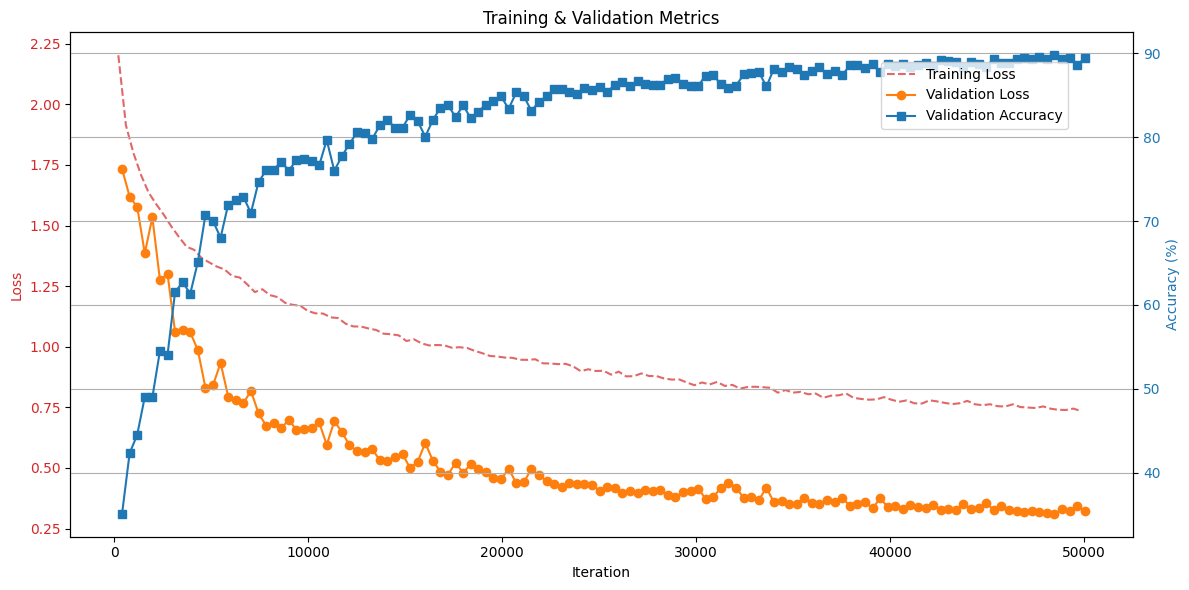

In [ ]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# loss function
criterion = nn.CrossEntropyLoss()


loss_history = []
iter_history = []
current_iter = 0
val_loss_history = []
val_acc_history = []
val_iter_history = []

# training loop
net.train()
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)


        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_iter += 1
        if i % print_every == print_every - 1:
            avg_loss = running_loss / print_every
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            iter_history.append(current_iter)
            loss_history.append(avg_loss)
            running_loss = 0.0

    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)
            pred = net(img)
            loss = criterion(pred, target)
            val_loss += loss.item()
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()

    avg_val_loss = val_loss / len(loader["test"])
    accuracy = 100 * correct / total

    print(f"[Epoch {epoch + 1:3d}] Validation loss: {avg_val_loss:.3f}, Accuracy: {accuracy:.2f}%")
    val_iter_history.append(current_iter)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(accuracy)

print("Finished Training")
# plot
fig, ax1 = plt.subplots(figsize=(12, 6))
plt.title('Training & Validation Metrics')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(iter_history, loss_history, color='tab:red', linestyle='--', alpha=0.7, label='Training Loss')
ax1.plot(val_iter_history, val_loss_history, color='tab:orange', marker='o', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(val_iter_history, val_acc_history, color='tab:blue', marker='s', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.tight_layout()
plt.grid(True)
plt.savefig('all_metrics_curve.png')

print("\nMetrics curve has been saved to all_metrics_curve.png")

print("\nTraining loss curve has been saved to training_loss_curve.png")

## Evaluating its accuracy

In [7]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)

        # make prediction
        pred = net(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 89.44%
